# Figures for making slides

This notebook makes figures meant to be used in slide presentations. The fonts will be larger and plots will be separated.

## Provenance information

Load libraries and print the version information.

In [29]:
%matplotlib inline
from __future__  import division
from tempfile import NamedTemporaryFile
from StringIO import StringIO
import numpy as np
import pandas as pd
from IPython.display import Image
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from fatiando.mesher import Tesseroid
from fatiando.constants import MEAN_EARTH_RADIUS
from fatiando.vis import myv, mpl
import fatiando

We'll make the graphics using the plotting functions in [Fatiando a Terra](http://www.fatiando.org). The engine for the 3D plots is [Mayavi](http://code.enthought.com/projects/mayavi/).

In [2]:
print('Fatiando a Terra version: {}'.format(fatiando.__version__))

Fatiando a Terra version: 0.3


In [3]:
!tessgz --version

1.2.0

We'll set the general style of matplotlib here so that we don't have to tweak this for every plot.

In [4]:
mpl.rc('font', size=12, family='Sans')

Make a folder for keeping the generated figures.

In [5]:
!mkdir -p presentation_figures

## Effect of distance and number of GLQ nodes on the computed effects

Generates the same figure in the paper but separated in 3 maps.

In [6]:
tess_area = (-52, -45, -23, -16)

In [7]:
modelfile = NamedTemporaryFile(delete=False)
modelfile.write('{} {} {} {} 0 -20000 2670'.format(*tess_area))
modelfile.close()
print(modelfile.name)

/tmp/tmpFBIUbU


In [8]:
area = (-70, -30, -35, 0)
shape = (100, 100)
pipeline = ' | '.join(
    ['tessgrd -r{area[0]}/{area[1]}/{area[2]}/{area[3]} -b{shape[0]}/{shape[1]} -z{height}',
     'tessgxy {model} -a -o{order:d}/{order:d}/{order:d}'])

In [9]:
cmd = pipeline.format(area=area, shape=shape, height=400e03, order=2, model=modelfile.name)
data = !$cmd
high = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [10]:
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=2, model=modelfile.name)
data = !$cmd
low = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [11]:
high_order = 30
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=high_order, 
                      model=modelfile.name)
data = !$cmd
low_highorder = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

Now all that's left is to make the figure and save it as EPS.

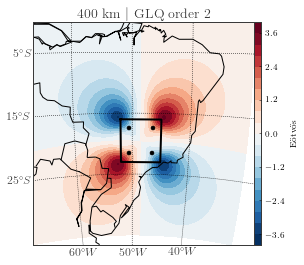

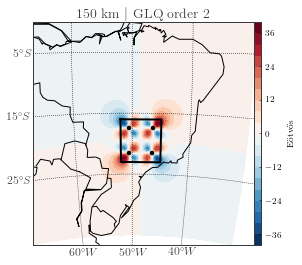

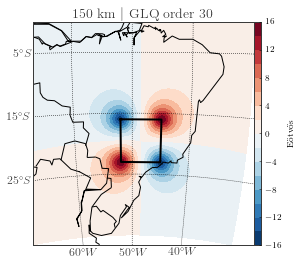

In [12]:
grids = [high, low, low_highorder]
orders = [2, 2, high_order]

bm = mpl.basemap(area, projection='poly')

w, e, s, n = tess_area
# To plot the outline of the tesseroid
tx, ty = bm([w, e, e, w, w], [n, n, s, s, n])
# Scale and make a list of the 2x2 GLQ nodes
nodes = np.array([-0.577350269, 0.577350269])
nodes_lon = 0.5*(e - w)*nodes + 0.5*(e + w)
nodes_lat = 0.5*(n - s)*nodes + 0.5*(n + s)
nodex, nodey = bm(*np.meshgrid(nodes_lon, nodes_lat))

for order, grid in zip(orders, grids):
    plt.figure(figsize=(5, 4))
    ax = plt.subplot(111)
    lon, lat, h, g = grid
    ax.set_title('{:.0f} km $|$ GLQ order {}'.format(h[0]/1000, order),
                 fontsize=14)
    vmax = np.abs(g).max()
    vmin = -vmax
    mpl.contourf(lon, lat, g, shape, 20, vmin=vmin, vmax=vmax, basemap=bm, 
                 cmap=mpl.cm.RdBu_r)
    mpl.colorbar(orientation='vertical', pad=0., aspect=30).set_label(r'E\"otv\"os')
    bm.plot(tx, ty, '-k', linewidth=2)
    if order == 2:
        bm.plot(nodex, nodey, 'ok', markersize=4)
    bm.drawparallels([-25, -15, -5], labels=[1, 0, 0, 0], linewidth=0.5)
    bm.drawmeridians([-60, -50, -40], labels=[0, 0, 0, 1], linewidth=0.5)
    mpl.draw_countries(bm, style='-')
    mpl.draw_coastlines(bm)
    plt.savefig('presentation_figures/tesseroid-example-o{}-h{}.png'.format(order, h[0]/1000),
                dpi=300, transparent=True)

Clean-up the temp file with the model.

In [13]:
!rm -f $modelfile.name

## Recursive discretization

In [14]:
tesseroid = Tesseroid(-55, -25, -80, -70, 500e3, 10e3)
point = [-40, -70, 900e3]

In [15]:
def setview(scene):
    scene.scene.camera.position = [
        13245978.057767538, -30621946.584093191, -7206532.4158068281]
    scene.scene.camera.focal_point = [
        -23549.659742131294, 2441999.8237691643, -6224267.6728611523]
    scene.scene.camera.view_angle = 2.0615843020800004
    scene.scene.camera.view_up = [
        -0.0023574328511045649, 0.028749561740884784, -0.99958386602128579]
    scene.scene.camera.clipping_range = [
        16338386.090352792, 55257696.473242983]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()

Plot the original tesseroid.

In [16]:
scene = myv.figure(zdown=False, size=(1200, 900))
myv.tesseroids(tesseroid.split(35, 35, 20), edges=False, color=(0.4, 0.4, 0.4))
myv.points([point], size=20000, spherical=True)
myv.meridians(range(0, 360, 30))
myv.parallels(range(-90, 0, 15))
myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
myv.continents(linewidth=2)
setview(scene)
myv.savefig('presentation_figures/tesseroid-algorithm-initial.png')
myv.mlab.close()

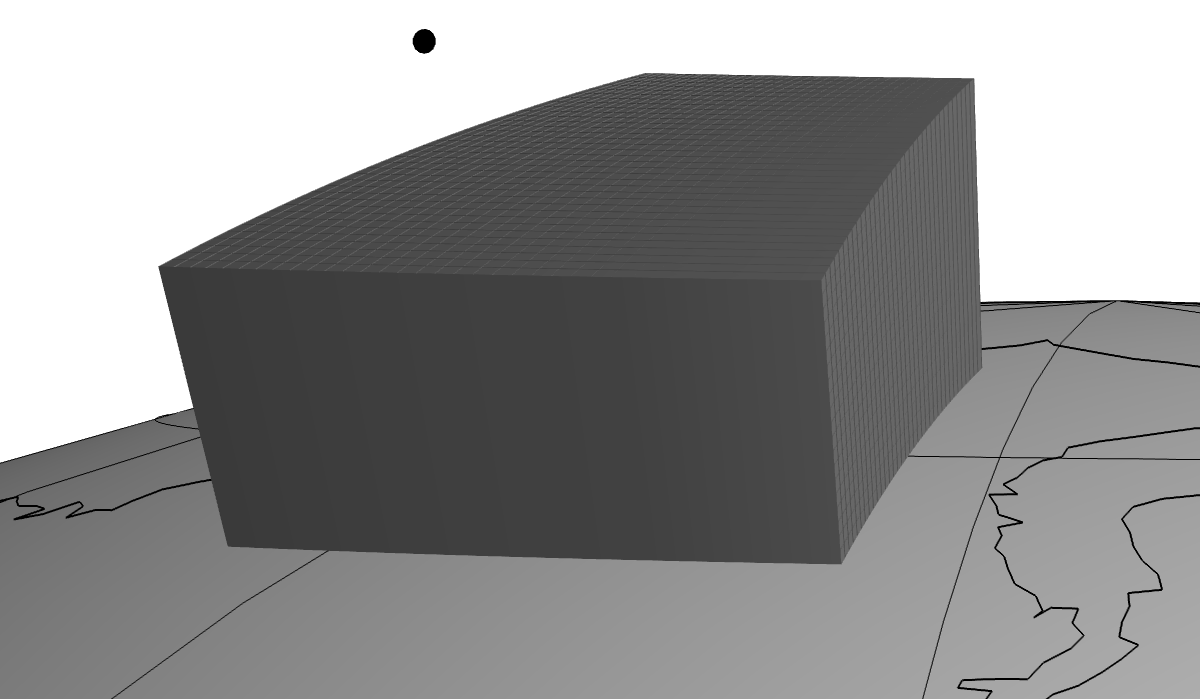

In [17]:
Image(filename='presentation_figures/tesseroid-algorithm-initial.png', width=800)

In [18]:
scene = myv.figure(zdown=False, size=(1200, 900))
myv.tesseroids(tesseroid.split(2, 2, 2), edges=False, color=(0.4, 0.4, 0.4))
myv.tesseroids(tesseroid.split(2, 2, 2), style='wireframe', linewidth=10, color=(0, 0, 0))
myv.points([point], size=20000, spherical=True)
myv.meridians(range(0, 360, 30))
myv.parallels(range(-90, 0, 15))
myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
myv.continents(linewidth=2)
setview(scene)
myv.savefig('presentation_figures/tesseroid-algorithm-split1.png')
myv.mlab.close()

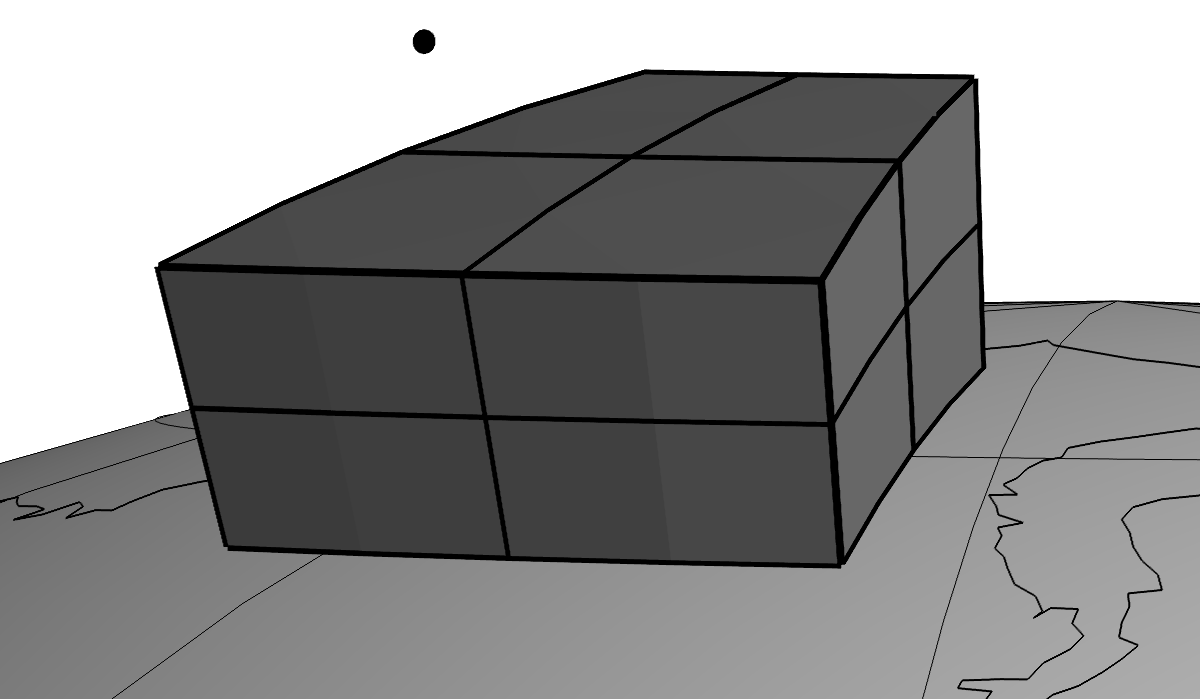

In [19]:
Image(filename='presentation_figures/tesseroid-algorithm-split1.png', width=800)

In [20]:
for i, t in enumerate(tesseroid.split(2, 2, 2)):
    scene = myv.figure(zdown=False, size=(1200, 900))
    myv.tesseroids([t], edges=False, color=(0.4, 0.4, 0.4))
    myv.tesseroids([t], style='wireframe', linewidth=5, color=(0, 0, 0))
    myv.points([point], size=20000, spherical=True)
    myv.tesseroids([tesseroid], style='wireframe', linewidth=5, color=(1, 0.2, 0.2))
    myv.meridians(range(0, 360, 30))
    myv.parallels(range(-90, 0, 15))
    myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
    myv.continents(linewidth=2)
    setview(scene)
    myv.savefig('presentation_figures/tesseroid-algorithm-split1-p{}.png'.format(i + 1))
    myv.mlab.close()

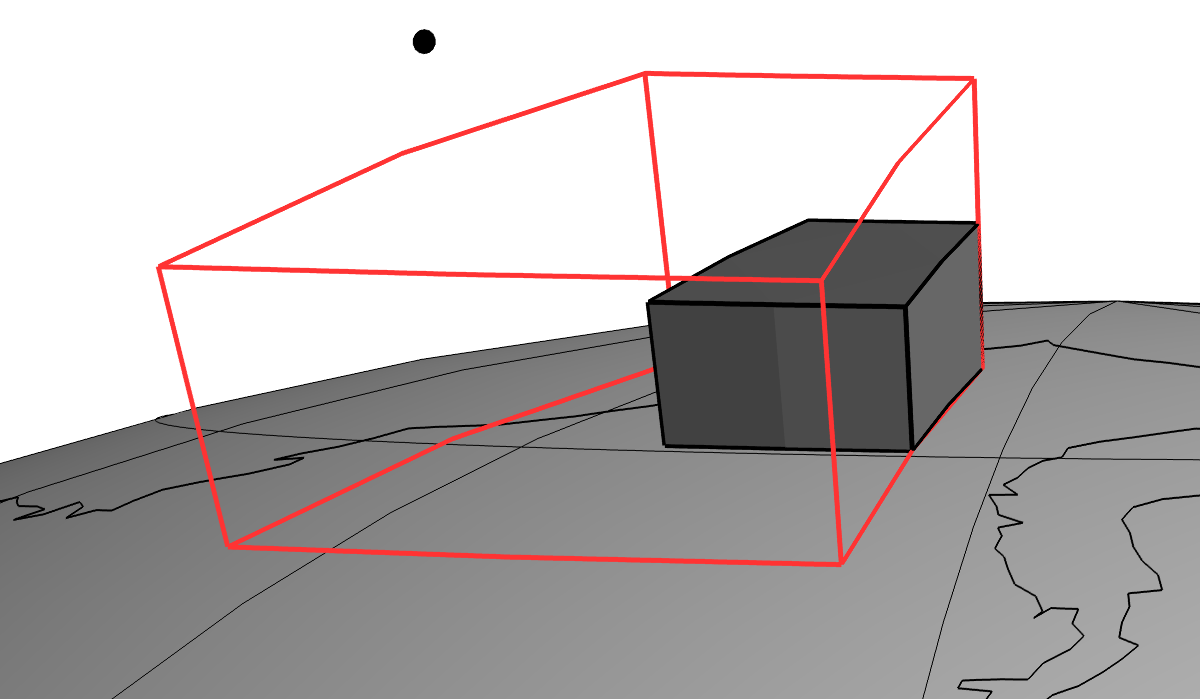

In [21]:
Image(filename='presentation_figures/tesseroid-algorithm-split1-p1.png', width=800)

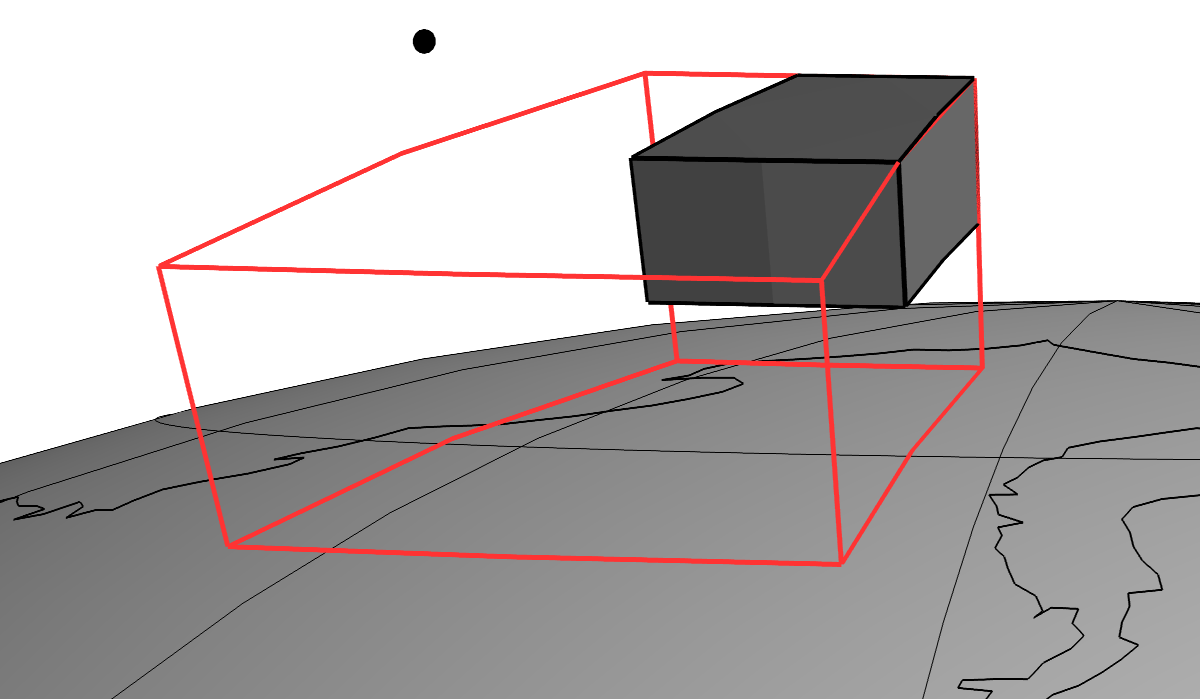

In [22]:
Image(filename='presentation_figures/tesseroid-algorithm-split1-p2.png', width=800)

In [23]:
scene = myv.figure(zdown=False, size=(1200, 900))
myv.tesseroids(tesseroid.split(2, 2, 2)[0].split(2, 2, 1), edges=False, color=(0.4, 0.4, 0.4))
myv.tesseroids(tesseroid.split(2, 2, 2)[0].split(2, 2, 1), style='wireframe', linewidth=10, color=(0, 0, 0))
myv.tesseroids([tesseroid], style='wireframe', linewidth=5, color=(1, 0.2, 0.2))
myv.points([point], size=20000, spherical=True)
myv.meridians(range(0, 360, 30))
myv.parallels(range(-90, 0, 15))
myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
myv.continents(linewidth=2)
setview(scene)
myv.savefig('presentation_figures/tesseroid-algorithm-split2.png')
myv.mlab.close()

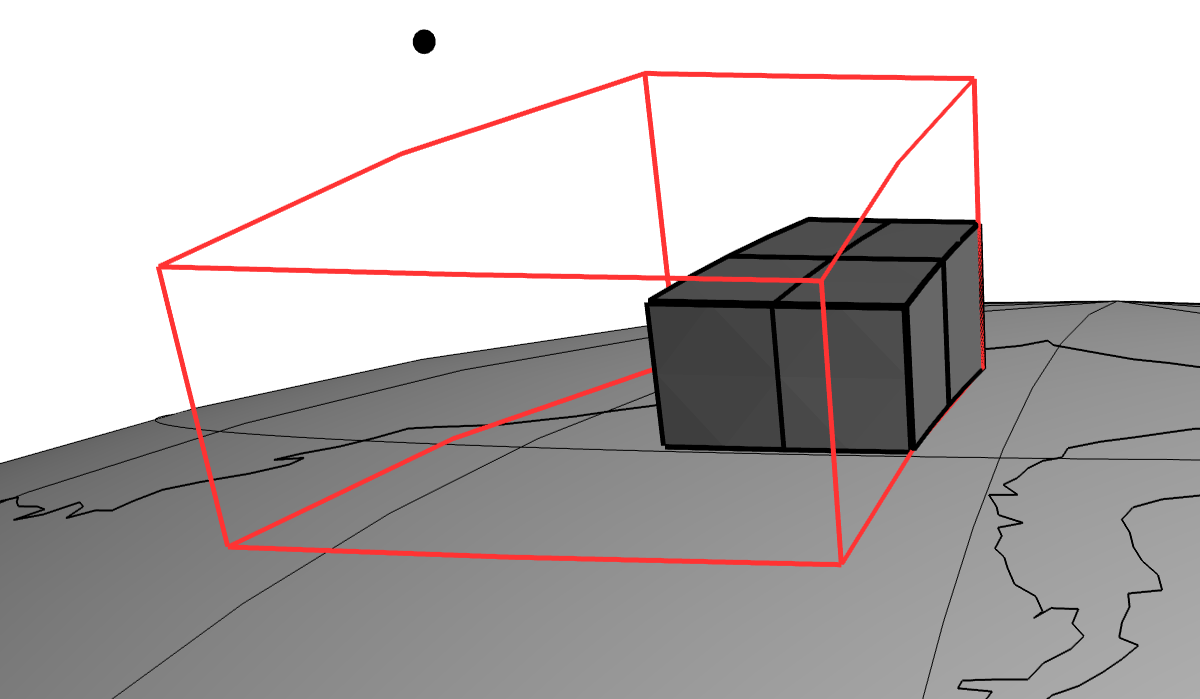

In [24]:
Image(filename='presentation_figures/tesseroid-algorithm-split2.png', width=800)

In [25]:
for i, t in enumerate(tesseroid.split(2, 2, 2)[0].split(2, 2, 1)):
    scene = myv.figure(zdown=False, size=(1200, 900))
    myv.tesseroids([t], edges=False, color=(0.4, 0.4, 0.4))
    myv.tesseroids([t], style='wireframe', linewidth=5, color=(0, 0, 0))
    myv.points([point], size=20000, spherical=True)
    myv.tesseroids([tesseroid], style='wireframe', linewidth=5, color=(1, 0.2, 0.2))
    myv.meridians(range(0, 360, 30))
    myv.parallels(range(-90, 0, 15))
    myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
    myv.continents(linewidth=2)
    setview(scene)
    myv.savefig('presentation_figures/tesseroid-algorithm-split2-p{}.png'.format(i + 1))
    myv.mlab.close()

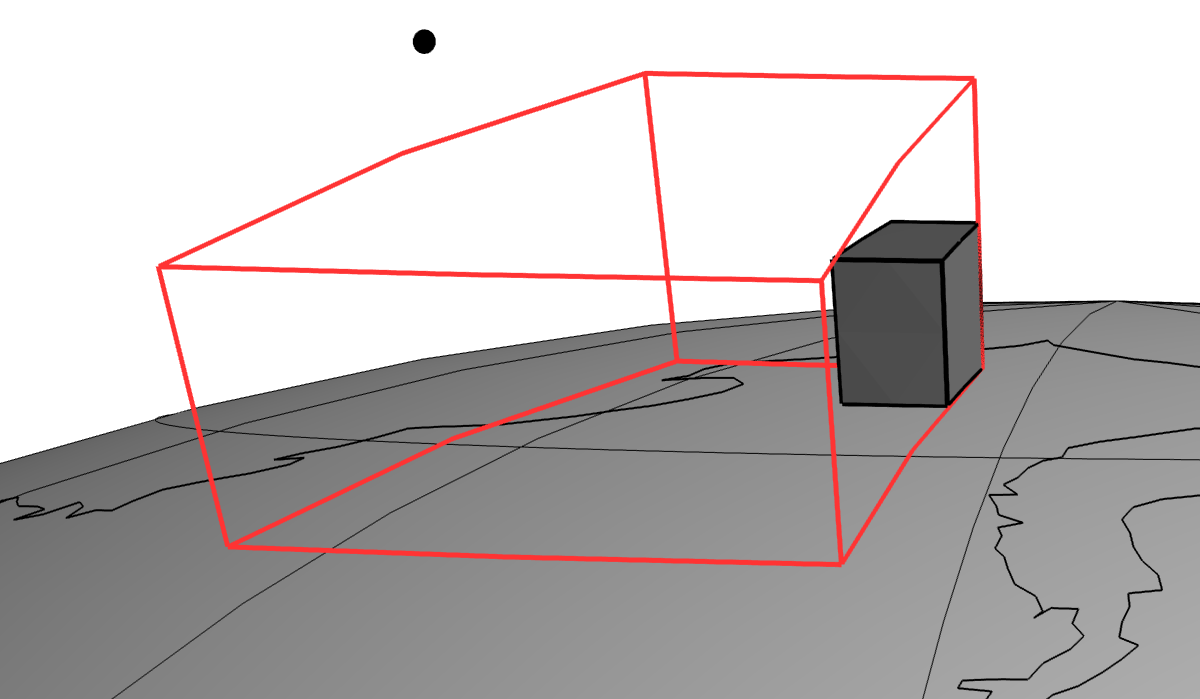

In [26]:
Image(filename='presentation_figures/tesseroid-algorithm-split2-p1.png', width=800)

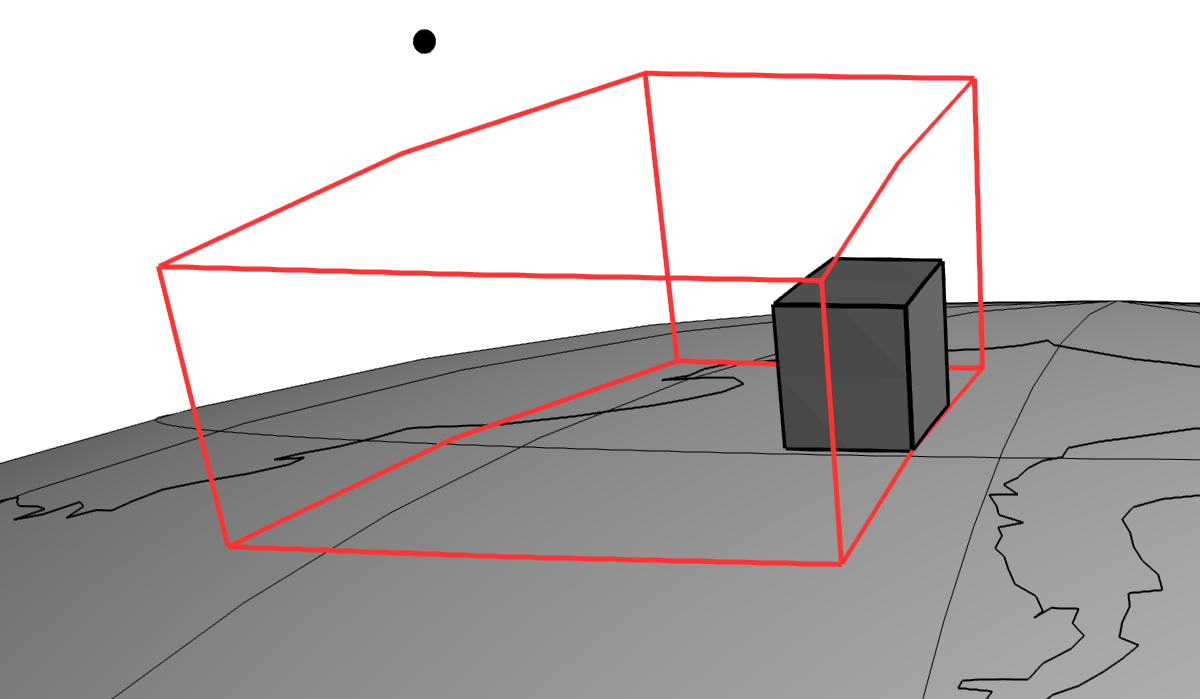

In [27]:
Image(filename='presentation_figures/tesseroid-algorithm-split2-p2.png', width=800)

# Results

In [36]:
plt.rcParams['axes.labelsize'] = 9.0  # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0  # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0  # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'sans'
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

In [31]:
shell = pd.read_csv('../data/shell-per-height.csv', index_col=0)

In [32]:
def load_max_diff(fname):
    data = pd.read_csv(fname)
    return data.groupby(['size', 'ratio']).max()

In [33]:
pole = load_max_diff('../data/difference-size-1-height-2000-pole.csv')
equator = load_max_diff('../data/difference-size-1-height-2000-equator.csv')
goce = load_max_diff('../data/difference-size-1-height-260000-pole.csv')
big = load_max_diff('../data/difference-size-30-height-2000-pole.csv')

In [34]:
ratio = pole.index.levels[1] # Get the unique values of the distance-size ratio used

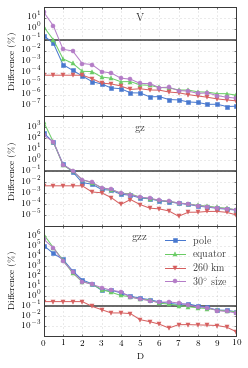

In [54]:
plotargs = dict(markeredgewidth=0.5)
styles = "-s -^ -v -o".split()
colors = [u'#4878cf', u'#6acc65', u'#d65f5f', u'#b47cc7']
fig, subplots = plt.subplots(3, 1, figsize=(3.33, 5), sharex='col')
axes = subplots.ravel()
fields = ['pot', 'gz', 'gzz']
titles = [r'V', r'gz', r'gzz']
for ax, f, title in zip(axes, fields, titles):
    ax.text(0.5, 0.9, title, fontsize=11, 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes)
    shell_low = np.abs(shell[shell.height == 2000][f].values)
    shell_high = np.abs(shell[shell.height == 260000][f].values)
    ax.plot(ratio, 100*pole[f]/shell_low, styles[0], label='pole', 
            color=colors[0], markeredgecolor=colors[0], 
            **plotargs)
    ax.plot(ratio, 100*equator[f]/shell_low, styles[1], label='equator', 
            color=colors[1], markeredgecolor=colors[1], 
            **plotargs)
    ax.plot(ratio, 100*goce[f]/shell_high, styles[2], label='260 km', 
            color=colors[2], markeredgecolor=colors[2], 
            **plotargs)
    ax.plot(ratio, 100*big[f]/shell_low, styles[3], label=r'$30^\circ$ size', 
            color=colors[3], markeredgecolor=colors[3], 
            **plotargs)
    ax.hlines(0.1, ratio.min(), ratio.max(), colors=['#3a3a3a'], linewidth=1.5)    
    ax.set_xlim(ratio.min(), ratio.max())
    ax.set_yscale('log')
    ax.set_xticks(range(11))
    ax.set_yticks(ax.get_yticks()[2:-2])
    ax.set_ylabel('Difference (\\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.minorticks_off()
ax = axes[-1]
ax.set_xlabel('D')
ax.legend(borderpad=0.5, numpoints=1, bbox_to_anchor=(1, 1), 
          frameon=False, fontsize=10)
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('presentation_figures/tesseroid-results-d-curves.png',
            dpi=300, transparent=True)

In [49]:
gzz = pd.read_csv('../data/difference-gzz-per-height-size-1-pole.csv', 
                  index_col=0).groupby(['height', 'ratio']).max()

In [50]:
heights = gzz.index.levels[0].values # Get the unique values of the computation height

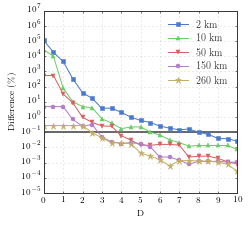

In [55]:
styles = "-s -^ -v -o -*".split()
colors = [u'#4878cf', u'#6acc65', u'#d65f5f', u'#b47cc7', u'#c4ad66']
fig = plt.figure(figsize=(3.33, 3))
ax = plt.subplot(111)
for h, sty, color in zip(heights, styles, colors):
    shell_value = np.abs(shell[shell.height == h]['gzz'].values)
    diff = 100*gzz.loc[int(h)]/shell_value
    markersize = 4
    if sty[-1] == '*':
        markersize = 7
    ax.plot(ratio, diff, sty, label='{:.0f} km'.format(h/1000), color=color, 
            markeredgewidth=0.5, markeredgecolor=color, markersize=markersize)
ax.hlines(0.1, ratio.min(), ratio.max(), colors=['#3a3a3a'], linewidth=1.5)    
ax.set_xlim(ratio.min(), ratio.max())
ax.set_yscale('log')
ax.set_xticks(range(11))
ax.set_yticks(ax.get_yticks())
ax.minorticks_off()
ax.grid(True, linewidth=0.5, color='#aeaeae')
ax.set_axisbelow(True)
ax.set_ylabel('Difference (\\%)')
ax.set_xlabel('D')
ax.legend(borderpad=0.5, numpoints=1, bbox_to_anchor=(1, 1), 
          frameon=False, fontsize=10)
plt.tight_layout(pad=0.25, h_pad=0, w_pad=0)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('presentation_figures/tesseroid-results-gzz.png',
            dpi=300, transparent=True)